In [17]:
import torch

device = torch.device("cpu")  # Force CPU usage
tensor = torch.tensor([1.0, 2.0, 3.0], device=device)
print(tensor.device)  # Should print 'cpu'


cpu


In [68]:
import os
import json
# import cv2
import easyocr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
from tqdm import tqdm

In [2]:
# Set paths
dataset_folder = "SROIE_filtered_dataset/"
image_folder = os.path.join(dataset_folder, "img")
entities_folder = os.path.join(dataset_folder, "entities")


In [3]:
# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


In [4]:
# Function to perform OCR using EasyOCR
def extract_text(image_path):
    result = reader.readtext(image_path, detail=0)
    return " ".join(result).strip()

In [5]:
# Extract text from images
ocr_results = []
for filename in tqdm(os.listdir(image_folder)):
    if filename.endswith(".jpg"):
        image_path = os.path.join(image_folder, filename)
        text = extract_text(image_path)
        ocr_results.append({"filename": filename, "text": text})

# Convert to DataFrame
df = pd.DataFrame(ocr_results)

100%|██████████| 239/239 [42:54<00:00, 10.77s/it] 


In [21]:
# Save to CSV
df.to_csv("receipt_transcripts.csv", index=False, encoding="utf-8")

In [ ]:
df = pd.read_csv("receipt_transcripts.csv")

# Load the company label CSV
df_labels = pd.read_csv("receipt_company_labels.csv")

# Extract filename without extensions to match
df["filename_clean"] = df["filename"].str.replace(".jpg", "", regex=False)
df_labels["filename_clean"] = df_labels["filename"].str.replace(".txt", "", regex=False)

# Merge based on cleaned filename
merged_df = df.merge(
    df_labels[["filename_clean", "company"]], 
    on="filename_clean", 
    how="left"
)

# Keep only the required fields
merged_df = merged_df[["filename", "text", "company"]]

# Save to a new CSV file (does NOT overwrite the original)
merged_df.to_csv("receipt_transcripts_with_company.csv", index=False)

print("Merged file saved as 'receipt_transcripts_with_company.csv'")

Merged file saved as 'receipt_transcripts_with_company.csv'


In [85]:
# Load transcript from the csv file if you don't want to run OCR 
df = pd.read_csv("receipt_transcripts_with_company.csv")

In [86]:
# Feature Extraction using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(df["text"]).toarray()


In [87]:
# Apply K-Means Clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df["cluster"] = kmeans.fit_predict(X)

In [88]:
# Apply PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Add PCA results to DataFrame
df["PC1"] = X_pca[:, 0]
df["PC2"] = X_pca[:, 1]

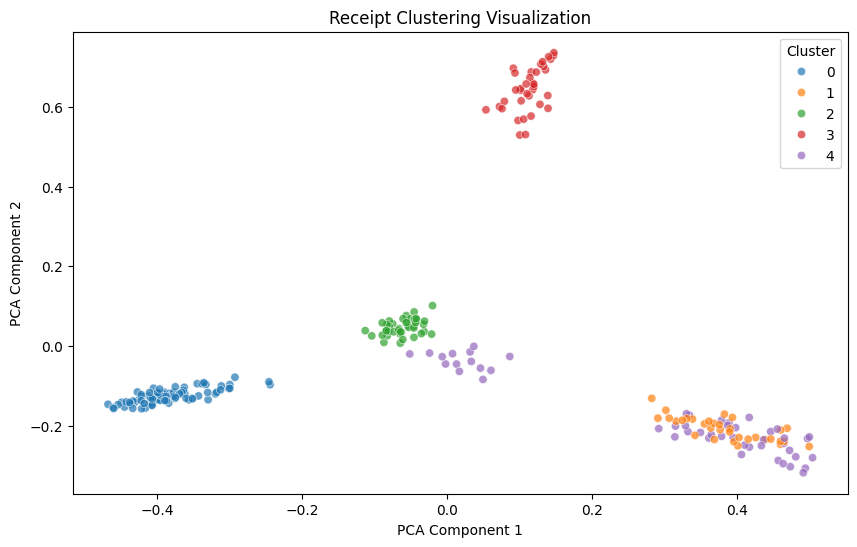

In [89]:
# Visualizing the Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x="PC1", y="PC2", hue="cluster", data=df, palette="tab10", alpha=0.7)
plt.title("Receipt Clustering Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

In [90]:
# Check original class distribution
print("Before SMOTE:", Counter(y))

Before SMOTE: Counter({np.int64(1): 76, np.int64(4): 69, np.int64(0): 44, np.int64(3): 36, np.int64(2): 14})


In [91]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["company"])  # Convert company names into integers

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [92]:
# Check new class distribution
print("After SMOTE:", Counter(y_resampled))

After SMOTE: Counter({np.int64(0): 76, np.int64(4): 76, np.int64(2): 76, np.int64(1): 76, np.int64(3): 76})


In [93]:
# Apply K-Means Clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters  = kmeans.fit_predict(X_resampled)

In [94]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_resampled)

# Convert y_resampled back to company names
companies_resampled = label_encoder.inverse_transform(y_resampled)

# Create a new DataFrame to store results
df_resampled = pd.DataFrame({
    "company": companies_resampled,
    "cluster": clusters,
    "pca1": X_pca[:, 0],
    "pca2": X_pca[:, 1]
})


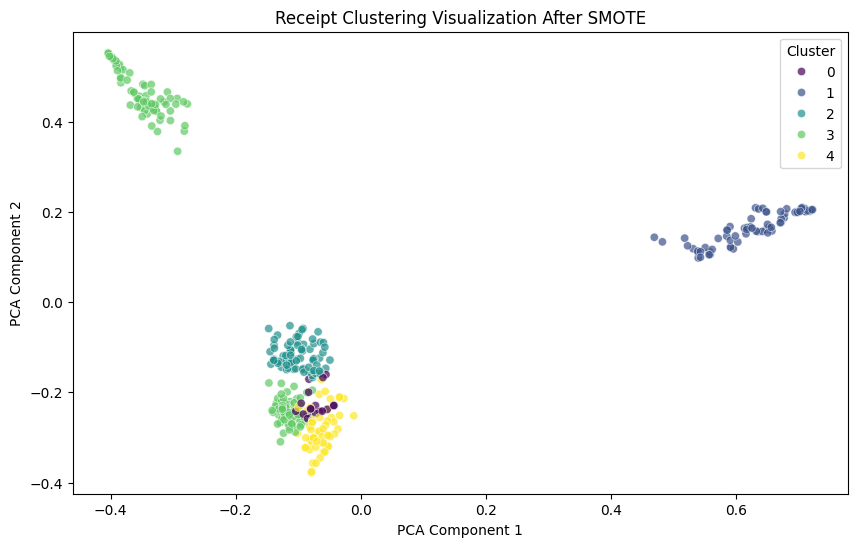

In [95]:
# Visualizing the Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x="pca1", y="pca2", hue="cluster", data=df_resampled, palette="viridis", alpha=0.7)
plt.title("Receipt Clustering Visualization After SMOTE")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

In [12]:
# Save clustered results
df.to_csv("receipt_clusters.csv", index=False)
print("Clustering completed and results saved!")

Clustering completed and results saved!


In [96]:
# Evaluation using Silhouette Score
sil_score_before_smote = silhouette_score(X, df["cluster"])
print(f"Silhouette Score: {sil_score_before_smote}")

sil_score_after_smote = silhouette_score(X_resampled, clusters)
print(f"Silhouette Score: {sil_score_after_smote}")

Silhouette Score: 0.14647939363032964
Silhouette Score: 0.20188454032809647


In [97]:
from sklearn.metrics import davies_bouldin_score

db_index_before_smote = davies_bouldin_score(X, df["cluster"])
print(f"Davies-Bouldin Index: {db_index_before_smote}")

db_index_after_smote = davies_bouldin_score(X_resampled, clusters)
print(f"Davies-Bouldin Index: {db_index_after_smote}")

Davies-Bouldin Index: 2.5809927083150805
Davies-Bouldin Index: 2.261296285556935


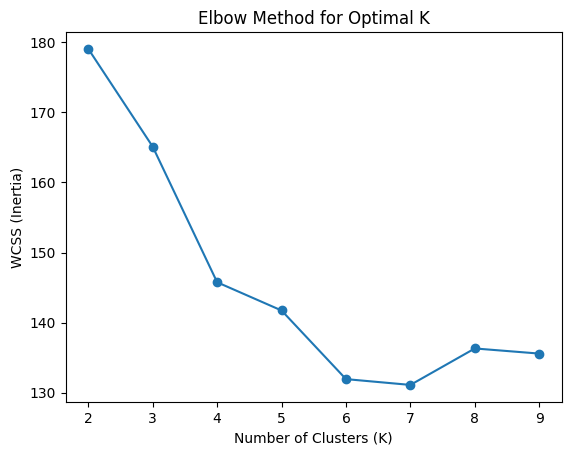

In [98]:
wcss = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 10), wcss, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS (Inertia)")
plt.title("Elbow Method for Optimal K")
plt.show()


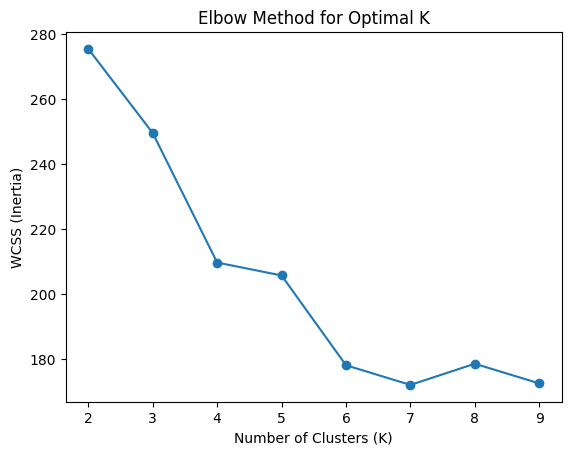

In [99]:
wcss = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_resampled)
    wcss.append(kmeans.inertia_)

plt.plot(range(2, 10), wcss, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS (Inertia)")
plt.title("Elbow Method for Optimal K")
plt.show()
